In [67]:
import yfinance as yf
TSLA = yf.Ticker("TSLA")
TSLA_hist = TSLA.history(period = "max")

In [69]:
TSLA_hist.head(10)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0
2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0
2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0
2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0
2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0
2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0
2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0
2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0
2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0


<AxesSubplot:xlabel='Date'>

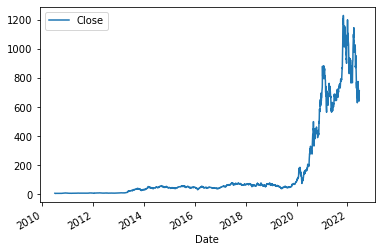

In [68]:
TSLA_hist.plot.line(y="Close",use_index = True)

In [70]:
#Taking stock prices at closing times and comparing them with 1 day before to see if price went up
data = TSLA_hist[["Close"]]
data = data.rename(columns = {"Close": "Actual_Close"})
data["Target"] = TSLA_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
#test whether there is class imbalance
data["Target"].value_counts()

1.0    1560
0.0    1455
Name: Target, dtype: int64

In [15]:
data.head(5)

,Actual_Close,Target
Date,,
2010-06-29,4.778,NaN
2010-06-30,4.766,0.0
2010-07-01,4.392,0.0
2010-07-02,3.840,0.0
2010-07-06,3.222,0.0


In [16]:
TSLA_prev = TSLA_hist.copy()
TSLA_prev = TSLA_prev.shift(1)
TSLA_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-30,3.800,5.000,3.508,4.778,93831500.0,0.0,0.0
2010-07-01,5.158,6.084,4.660,4.766,85935500.0,0.0,0.0
2010-07-02,5.000,5.184,4.054,4.392,41094000.0,0.0,0.0
2010-07-06,4.600,4.620,3.742,3.840,25699000.0,0.0,0.0


In [73]:
#cutting off first day of stock closing price and joining predictor columns to stock data beginning on second day of opening
predictors = ["Close","High","Low","Open","Volume"]
data = data.join(TSLA_prev[predictors]).iloc[1:]

In [72]:
data.head(5)

,Actual_Close,Target
Date,,
2010-06-29,4.778,NaN
2010-06-30,4.766,0.0
2010-07-01,4.392,0.0
2010-07-02,3.840,0.0
2010-07-06,3.222,0.0


In [74]:
#classifying whether price went up or down, set msp at 200 so as to not over fit to test data benefiting generalizability
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [82]:
from sklearn.metrics import precision_score
import pandas as pd
#changed preds to series to make predictions easier to read
# Evaluate precision of predictions

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

#calculate precision score
precision_score(test["Target"], preds)

0.5497382198952879

In [83]:
preds

Date
2014-06-20    0.0
2014-06-23    0.0
2014-06-24    0.0
2014-06-25    0.0
2014-06-26    0.0
             ... 
2017-06-06    0.0
2017-06-07    0.0
2017-06-08    0.0
2017-06-09    0.0
2017-06-12    0.0
Length: 750, dtype: float64

In [37]:
#adding predictions with target to look at more easily
combined = pd.concat({"Target":test["Target"],"Predictions":preds},axis = 1)
combined.head(10)

,Target,Predictions
Date,,
2022-01-27,0.0,1.0
2022-01-28,1.0,1.0
2022-01-31,1.0,1.0
2022-02-01,0.0,1.0
2022-02-02,0.0,1.0
2022-02-03,0.0,1.0
2022-02-04,1.0,1.0
2022-02-07,0.0,1.0
2022-02-08,1.0,1.0


<AxesSubplot:xlabel='Date'>

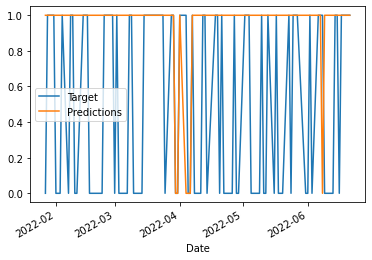

In [85]:
combined.plot()

In [117]:
#creating backtest by looping over data to predict next parts of dataset

def backtest(data, model, predictors, start=1000, step=10):
    predictions = []
    # loop back over data set in increments
    for i in range(start, data.shape[0], step):
        # Split data into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)
predictions = backtest(data, model, predictors)
predictions["Predictions"].value_counts()


0.0    1799
1.0     216
Name: Predictions, dtype: int64

In [115]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5

In [ ]:
#produce ratios for the algorithm to read in and become more accurate with predicctions
#assigning ratios as columns in dataframes to act as new predictors

In [118]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [119]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [120]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [121]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5202312138728323

In [122]:
predictions["Predictions"].value_counts()

0.0    1477
1.0     173
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

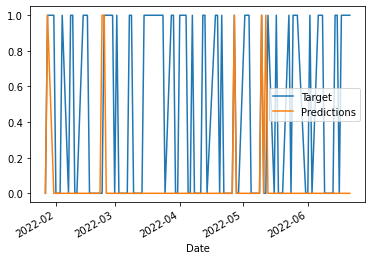

In [123]:
predictions.iloc[-100:].plot()